In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
#from torchvision.datasets import CIFAR10
import torchvision.models as models
%matplotlib inline

In [2]:
data_dir = os.path.join(os.getcwd(),'notebook', 'fruits-360')
dataset_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Test')

dataset = ImageFolder(dataset_dir, transform=ToTensor())
test = ImageFolder(test_dir, transform=ToTensor())

In [3]:
# Fixed rand. seed for reproducibility of results
random_seed = 21
torch.manual_seed(random_seed)

In [4]:
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train, val = random_split(dataset, [train_size, val_size])

print('Training data:   {} entries'.format(len(train)))
print('Validation data: {} entries'.format(len(val)))
print('Test data:       {} entries'.format(len(test)))

Training data:   642 entries
Validation data: 276 entries
Test data:       309 entries


In [5]:
# def show_example(img, label):
#     print('Label: ', dataset.classes[label], "("+str(label)+")")
#     plt.imshow(img.permute(1, 2, 0))

# show_example(*dataset[500])

In [6]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# hyperparams
lr = 0.001
batch_size = 32
num_classes = 2
num_epochs = 2
input_size = np.prod(dataset[0][0].shape)  # collapse all dimensions to calculate raw size

In [8]:
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test, batch_size=batch_size*4, shuffle=False, num_workers=4)

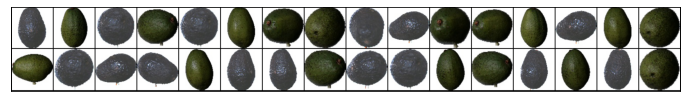

In [9]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_loader)

## 1. Feedforward Neural Network

In [10]:
# check training accuracy
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0    
    model.eval()  # turn on evaluation mode

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print(f"Accuracy {float(num_correct) / float(num_samples) * 100}")
    
    model.train()  # go back to training mode

In [11]:
# Inspired by: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/4bd862577ae445852da1c1603ade344d3eb03679/ML/Pytorch/Basics/pytorch_simple_fullynet.py
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN, self).__init__()
        self.linear_1 = nn.Linear(input_size, 16)
        self.linear_2 = nn.Linear(16, 4)
        self.linear_3 = nn.Linear(4, output_size)
    
    def forward(self, x):
        # TODO flatten?
        # x = x.view(x.size(0), -1)
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        out = self.linear_3(out)
        return out

In [12]:
# initialise feedforward model
model = NN(input_size=input_size, output_size=num_classes)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
# train network
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    for batch_idx, (data, targets) in enumerate(train_loader):
        # use CUDA if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        data = data.reshape(data.shape[0], -1)

        # forward
        scores = model(data)
        loss = loss_fn(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    check_accuracy(train_loader, model)
    check_accuracy(val_loader, model)

Epoch 1
Accuracy 100.0
Accuracy 100.0
Epoch 2
Accuracy 100.0
Accuracy 100.0


In [15]:
check_accuracy(train_loader, model)

Accuracy 100.0


In [16]:
check_accuracy(val_loader, model)

Accuracy 100.0


In [17]:
check_accuracy(test_loader, model)

Accuracy 100.0


In [18]:
# temp_loader = DataLoader(dataset[500], 1, shuffle=True, num_workers=4, pin_memory=True)
# for x, y in temp_loader:
#     scores = model(x)
# # _, predictions = scores.max(1)
# # num_correct += (predictions == y).sum()
# # num_samples += predictions.size(0)

In [19]:
torch.save(model, 'avocado_classifier.pth')